In [45]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from collections import defaultdict

In [46]:
# Load data

# Parse GTF (GENCODE v19)
gtf_columns = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']

gencode_df = pd.read_csv(
    "/Users/kanadb/Work/IIT-KGP Summer/cancer-research/datasets/UCSC-Xena-Somatic-Mutation-(SNP-and-INDEL)-MC3-Gene-Level-Non-Silent-Mutation/gencode.v19.annotation.gtf",
    sep='\t',
    comment='#',
    header=None,
    names=gtf_columns
)

print(gencode_df.shape)
gencode_df.head()

(2619444, 9)


,seqname,source,feature,start,end,score,strand,frame,attribute
0,chr1,HAVANA,gene,11869,14412,.,+,.,"gene_id ""ENSG00000223972.4""; transcript_id ""EN..."
1,chr1,HAVANA,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972.4""; transcript_id ""EN..."
2,chr1,HAVANA,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972.4""; transcript_id ""EN..."
3,chr1,HAVANA,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972.4""; transcript_id ""EN..."
4,chr1,HAVANA,exon,13221,14409,.,+,.,"gene_id ""ENSG00000223972.4""; transcript_id ""EN..."


In [47]:
# Print the first attribute string
print(gencode_df.loc[0, 'attribute'])

gene_id "ENSG00000223972.4"; transcript_id "ENSG00000223972.4"; gene_type "pseudogene"; gene_status "KNOWN"; gene_name "DDX11L1"; transcript_type "pseudogene"; transcript_status "KNOWN"; transcript_name "DDX11L1"; level 2; havana_gene "OTTHUMG00000000961.2";


In [57]:
# Filter for protein-coding exons
gencode_df = gencode_df[(gencode_df['feature'] == 'exon') & 
                  (gencode_df['attribute'].str.contains('gene_type "protein_coding"'))] # NOTE: Number of non protein-coding genes containing exon info = 0
                                                                                        # Comment this line and rerun -> gencode_df shape will be the exact same

# Extract gene names and exon lengths
gencode_df['gene_name'] = gencode_df['attribute'].str.extract(r'gene_name "([^"]+)"')
gencode_df['exon_length'] = gencode_df['end'] - gencode_df['start'] + 1  # 1-based coordinates

# Sum exonic lengths per gene
gene_lengths = gencode_df.groupby('gene_name')['exon_length'].sum().reset_index()
gene_lengths.columns = ['gene', 'exonic_length_bp']

print(gene_lengths.shape)
gene_lengths.head()

(20242, 2)


,gene,exonic_length_bp
0,A1BG,7549
1,A1CF,24504
2,A2M,11826
3,A2ML1,15888
4,A3GALT2,1881


In [49]:
# Load MC3 gene-level mutation matrix
mutation_df = pd.read_csv(
    "/Users/kanadb/Work/IIT-KGP Summer/cancer-research/datasets/UCSC-Xena-Somatic-Mutation-(SNP-and-INDEL)-MC3-Gene-Level-Non-Silent-Mutation/mc3_gene_level_BRCA_mc3_gene_level.txt", 
    sep="\t",
    index_col=0
)

mutation_df.index.name = 'gene'

print(mutation_df.shape)
mutation_df.head()

(40543, 791)


,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5L-AAT1-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
gene,,,,,,,,,,,,,,,,,,,,,
UBE2Q2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHMP1B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PSMA2P1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SHQ1P1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPHL1P,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# Mutation summary stats
mutation_freq_per_gene = mutation_df.sum(axis=1).sort_values(ascending=False)
mutation_burden_per_sample = mutation_df.sum(axis=0).sort_values(ascending=False)

print("Top 10 most frequently mutated genes:")
display(mutation_freq_per_gene.head(10))

print("\nTop 10 samples with highest mutation burden:")
display(mutation_burden_per_sample.head(10))

Top 10 most frequently mutated genes:


gene
PIK3CA    273
TP53      264
TTN       137
CDH1      102
GATA3      97
MUC16      78
KMT2C      77
MAP3K1     66
SYNE1      50
PTEN       48
dtype: int64


Top 10 samples with highest mutation burden:


TCGA-AC-A23H-01    3301
TCGA-EW-A2FV-01    3169
TCGA-D8-A27V-01    2609
TCGA-BH-A18G-01    1133
TCGA-5L-AAT1-01     947
TCGA-D8-A1XK-01     883
TCGA-AO-A128-01     794
TCGA-D8-A27G-01     740
TCGA-D8-A1XQ-01     739
TCGA-AO-A03M-01     683
dtype: int64

In [51]:
# Map GENCODE Lengths to MC3 Mutations

# mutation_df has gene names as index
# gene_lengths has a 'gene' column and 'exon_length' column

mutation_with_lengths = mutation_df.merge(
    gene_lengths,
    left_index=True,   # Use gene names from mutation_df's index
    right_on='gene',   # Match with gene column in gene_lengths
    how='left'         # Left Join -> Keeps all rows from mutation_df (even if not in gene_lengths)
)

# Move 'gene' back to index (for consistency)
mutation_with_lengths.set_index('gene', inplace=True)

print(mutation_with_lengths.shape)
mutation_with_lengths.head()

(40543, 792)


,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5L-AAT1-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,...,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01,exonic_length_bp
gene,,,,,,,,,,,,,,,,,,,,,
UBE2Q2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14866.0
CHMP1B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3489.0
PSMA2P1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
SHQ1P1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
CPHL1P,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [52]:
# Calculate mutation rate per megabase of exon length
mutation_with_lengths['mutation_rate'] = (
    mutation_with_lengths.iloc[:, :-2].sum(axis=1) /  # sum of mutations across all samples
    (mutation_with_lengths['exonic_length_bp'] / 1e6)  # convert exon length to megabases
)

# Drop NaN exon lengths
mutation_with_lengths_clean = mutation_with_lengths.dropna(subset=['exonic_length_bp'])

# FEATURE MATRIX
# Get top mutated genes by mutation rate
gene_mutation = mutation_with_lengths_clean[['mutation_rate']].sort_values('mutation_rate', ascending=False)

# Top gene names along with mutation rates
print(gene_mutation.shape)
print(gene_mutation.head(20))

# Save to csv file
gene_mutation.to_csv("UCSC-TCGA-BRCA-Somatic-Mutation-MC3_Mutation-Rate_Feature-Matrix.csv")

(19536, 1)
            mutation_rate
gene                     
PIK3CA       25504.484305
HIST1H3B     25423.728814
HIST1H4L     13736.263736
GATA3        13721.884283
HIST1H2AK    13043.478261
AL035406.1   12345.679012
TP53         10923.741485
HIST1H4D     10899.182561
HIST1H3F     10729.613734
HIST1H2BH     9411.764706
AC022400.2    9009.009009
HIST1H2BG     8988.764045
HIST1H4K      8474.576271
HIST1H4J      8021.390374
AC006486.9    7886.435331
HIST1H2AD     7633.587786
OR8H2         7454.739084
OR5I1         7407.407407
HIST2H3D      7299.270073
TMEM190       6745.362563


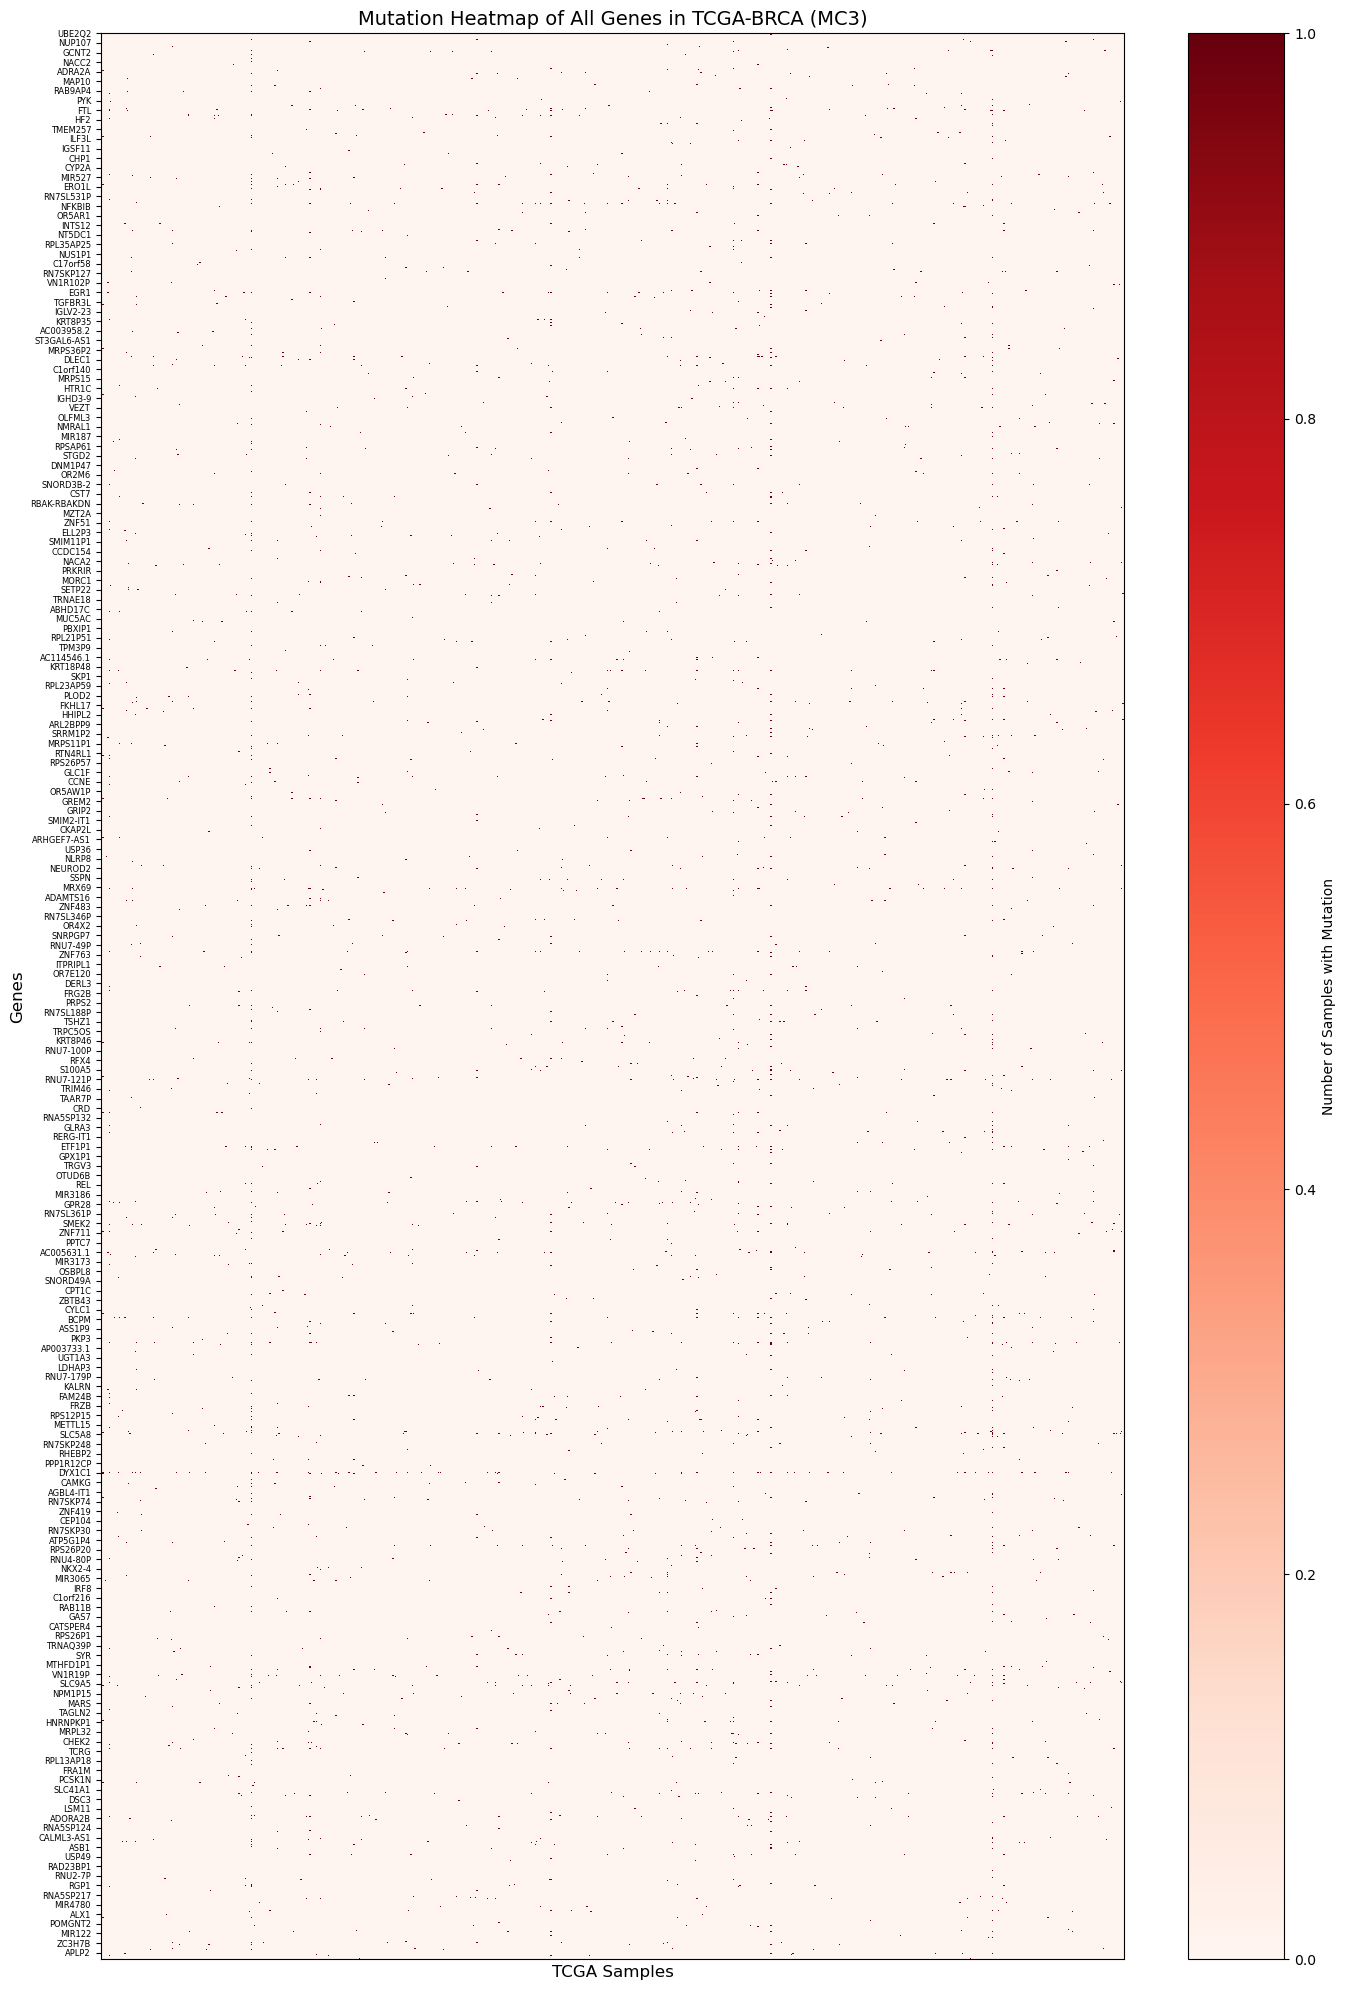

In [53]:
# Plot Heatmap for All Genes

# Get all gene names from mutation_df
all_genes = mutation_df.index

# Subset mutation matrix for all genes
heatmap_matrix = mutation_df.values  # shape: (genes × samples)

# Plot heatmap with gradient color
plt.figure(figsize=(14, 20))  # Adjust size as needed
img = plt.imshow(heatmap_matrix, aspect='auto', cmap='Reds', interpolation='none')

# Add gradient colorbar
cbar = plt.colorbar(img)
cbar.set_label("Number of Samples with Mutation", fontsize=10)

# Axis labels
plt.xlabel("TCGA Samples", fontsize=12)
plt.ylabel("Genes", fontsize=12)
plt.title("Mutation Heatmap of All Genes in TCGA-BRCA (MC3)", fontsize=14)

# Y-tick labeling (sparse)
# Compute how often to show gene names to avoid clutter
yticks_every = max(len(all_genes) // 200, 1) # Show ~200 gene names max

# Set Y-axis ticks (gene name at every 'yticks_every' interval)
plt.yticks(
    ticks=range(0, len(all_genes), yticks_every),
    labels=[all_genes[i] for i in range(0, len(all_genes), yticks_every)],
    fontsize=6
)

# Hide x-axis ticks
plt.xticks([])

plt.tight_layout()
plt.show()

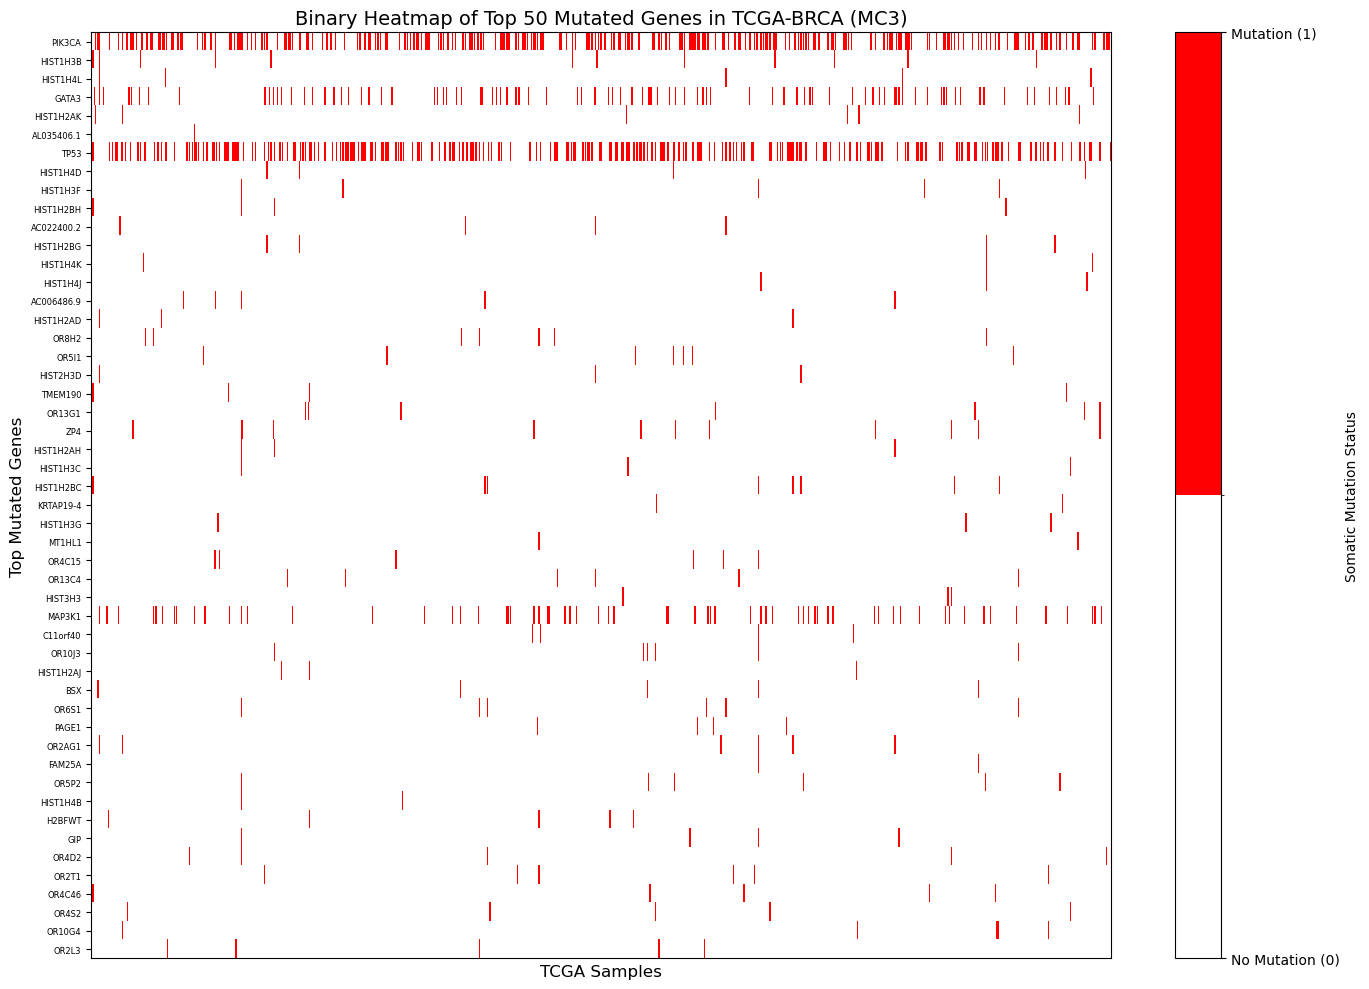

In [54]:
# Plot Binary Heatmap for Top 20 Mutated Genes

# Select top 50 mutated genes by mutation rate
top_50_genes = gene_mutation.head(50).index

# Subset mutation matrix for these genes
heatmap_matrix = mutation_df.loc[top_50_genes].values

# Define binary colormap (white for 0, red for 1)
binary_cmap = ListedColormap(["white", "red"])
norm = BoundaryNorm([0, 0.5, 1], binary_cmap.N)

# Plot heatmap
plt.figure(figsize=(14, 10))
img = plt.imshow(heatmap_matrix, aspect='auto', cmap=binary_cmap, norm=norm, interpolation='none')

# Add discrete colorbar
cbar = plt.colorbar(img, ticks=[0, 1])
cbar.ax.set_yticklabels(['No Mutation (0)', 'Mutation (1)'])
cbar.set_label("Somatic Mutation Status", fontsize=10)

# Axis labels
plt.xlabel("TCGA Samples", fontsize=12)
plt.ylabel("Top Mutated Genes", fontsize=12)
plt.title("Binary Heatmap of Top 50 Mutated Genes in TCGA-BRCA (MC3)", fontsize=14)

# Y-tick labeling (sparse)
# Compute how often to show gene names to avoid clutter
yticks_every = max(len(top_50_genes) // 100, 1) # Show ~100 gene names max

# Set Y-axis ticks (gene name at every 'yticks_every' interval)
plt.yticks(
    ticks=range(0, len(top_50_genes), yticks_every),
    labels=[top_50_genes[i] for i in range(0, len(top_50_genes), yticks_every)],
    fontsize=6
)

plt.xticks([])

plt.tight_layout()
plt.show()

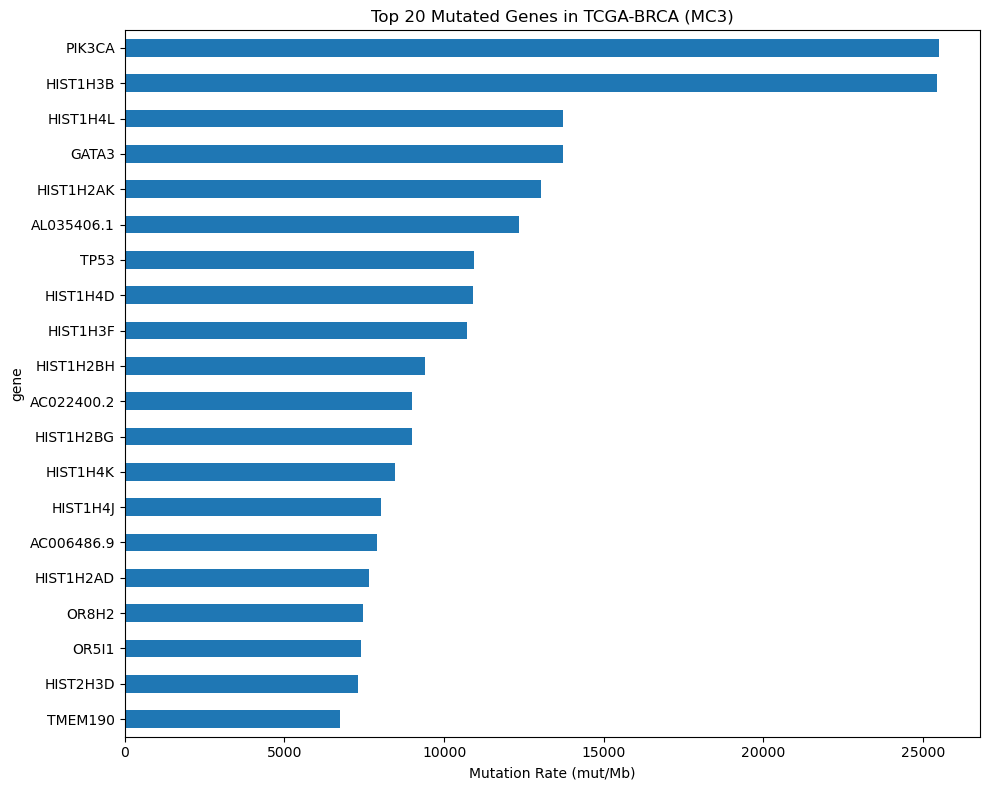

In [55]:
# Plot top 20 mutated genes
top20 = gene_mutation.head(20)
top20.plot(kind='barh', figsize=(10, 8), legend=False)
plt.xlabel("Mutation Rate (mut/Mb)")
plt.title("Top 20 Mutated Genes in TCGA-BRCA (MC3)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()